In [1]:
from Binaries import *

class ElectronicsError(Exception) : pass
class SignalError(Exception) : pass

def calculate_baseline(*args) -> list :

    baselines = []
    for window in args:

        while True:

            mode, count = None, 0
            ''
            # calculate mode of the trace windows
            for value in range(int(min(window)), int(max(window))):
                current_count = window.count(value)
                if current_count > count:
                    mode, count = value, current_count

            upper, lower = mode + 2* np.std(window), mode - 2* np.std(window)
            to_remove = [bin for bin in window if bin > upper or bin < lower]           
            if to_remove != []: [window.remove(value) for value in to_remove]
            else: break

        baselines.append([np.mean(window), np.std(window)])

    return baselines
    

# Implementation of Tobias Schulz baseline algorithm in python
def corrected_baseline(trace : np.ndarray) -> np.ndarray :

    (i, sigma_i), (f, sigma_f) = calculate_baseline(list(trace[:300]), list(trace[-300:]))
    delta_B, sigma_B = f - i, np.sqrt(sigma_i**2 + sigma_f**2)

    # if delta_B >= 5 * sigma_B: raise ElectronicsError                               # discard trace
    
    # elif 5 * sigma_B > delta_B >= 0:                                                # approx. constant
        
    #     Baseline, _ =  calculate_baseline(list(trace))[0]
    #     return trace - Baseline

    # elif 0 > delta_B >= -sigma_B or (-sigma_B > delta_B and (max(trace) - i) < 50): # step function

    #     front, end = trace[:np.argmax(trace)], trace[np.argmax(trace):]
    #     return np.array(list(front - i) + list(end - f))
    
    # elif -sigma_B > delta_B:                                                        # signal undershoot
        
    interpolated_baseline = [i + delta_B * (bin - 300)/1448 for bin in range(300, 1748)]
    interpolated_baseline += [f for i in range(300)]
    interpolated_baseline = np.array(interpolated_baseline)
    
    q_front = np.sum(trace[:300] - i)                                           # front estimate integral
    tau     = 41e-6 / 8.33e-9                                                   # decay constant ~4922 bins
    bins    = np.array(range(1748))                                             # bin difference from start

    for iteration in range(4):
        
        intermediate_trace = trace[300:] - interpolated_baseline
        q_ref = q_front + np.sum(intermediate_trace[:-150])

        if q_ref < 0: raise ElectronicsError

        interpolated_baseline = i + delta_B * np.cumsum(intermediate_trace) / q_ref * np.exp(-bins / tau)    

    return i, np.array(interpolated_baseline)

In [2]:
traces = np.loadtxt("/cr/tempdata01/filip/iRODS/jaco/jaco_randoms0026.csv")

In [10]:
for i, trace in enumerate(traces):

    if max(trace) > 50:
        traces = np.delete(traces, (i, i + 1, i + 2), axis = 0)
        
        break

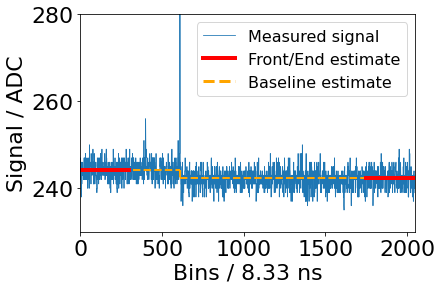

In [4]:
undershoot = np.zeros(2048)
undershoot[np.argmax(trace):] += 2
example_trace = 245 + trace - undershoot

x = range(len(example_trace))

front, end = list(example_trace[:300]), list(example_trace[-300:])

(B_front, _), (B_end, _) = calculate_baseline(front, end)

plt.plot(x, example_trace, label = "Measured signal", ls = "solid", lw = 0.8)
plt.plot([np.argmax(trace), np.argmax(trace)], [B_front, B_end], lw = 2, c = "orange", ls = "--")
plt.plot([0, np.argmax(trace)], [B_front, B_front], lw = 2, c = "orange", ls = "--")
plt.plot([np.argmax(trace), 2048], [B_end, B_end], lw = 2, c = "orange", ls = "--")
# plt.plot([0, 2048], [B_end, B_end], lw = 1, c = "orange", ls = "--")
plt.plot([0, 300], [B_front, B_front], lw = 4, c = "red")
plt.plot([1748, 2048], [B_end, B_end], lw = 4, c = "red")
plt.plot([],[], c = "red", lw = 4, label= "Front/End estimate")
plt.plot([],[], c = "orange", lw = 3, label= "Baseline estimate", ls = "--")
plt.xlabel("Bins / 8.33 ns")
plt.ylabel("Signal / ADC")
plt.ylim(230, 280)
plt.xlim(0, 2048)
plt.legend(fontsize = 16)

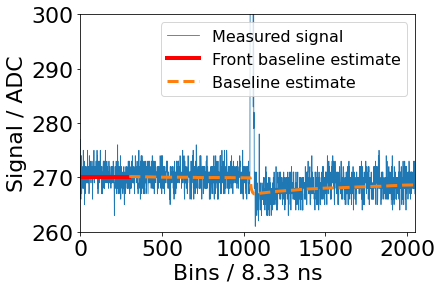

In [11]:
undershoot = np.zeros(2048)
undershoot[np.argmax(trace):] -= [int(x) + 1 for x in 4 * np.exp(-np.arange(0, 2048 - np.argmax(trace), 1) * 8.33e-9 / 2e-6)]
example_trace = trace + 271 + undershoot

x = range(len(example_trace))

front, end = list(example_trace[:300]), list(example_trace[-300:])
(B_front, _), (B_end, _) = calculate_baseline(front, end)
B_front, baseline = corrected_baseline(example_trace)

# mock_baseline = np.zeros(2048) + 271
# mock_baseline[np.argmax(trace):] -= [int(x) + 3 for x in 10 * np.exp(-np.arange(0, 2048 - np.argmax(trace), 1) * 8.33e-9 / 2e-6)]

plt.plot(x, example_trace, label = "Measured signal", ls = "solid", lw = 0.8)
plt.plot([0, 300], [B_front, B_front], c = "red", lw = 4, label = "Front baseline estimate")
plt.plot(range(300, 2048), 3.2 * (baseline - B_front) + B_front, lw = 3, label = "Baseline estimate", ls = "--")
plt.ylim(260, 300)
plt.xlim(0, 2048)

plt.xlabel("Bins / 8.33 ns")
plt.ylabel("Signal / ADC")
plt.legend(fontsize = 16)